### Building chatbot with Multiple tools using Langgraph

##### Aim
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [3]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all i need")

'Published: 2024-02-12\nTitle: The I/O Complexity of Attention, or How Optimal is Flash Attention?\nAuthors: Barna Saha, Christopher Ye\nSummary: Self-attention is at the heart of the popular Transformer architecture, yet\nsuffers from quadratic time and memory complexity. The breakthrough\nFlashAttention algorithm revealed I/O complexity as the true bottleneck in\nscaling Transformers. Given two levels of memory hierarchy, a fast cache (e.g.\nGPU on-chip SRAM) and a slow memory (e.g. GPU high-bandwidth'

In [5]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [6]:
wiki.invoke("What is ML")

'Page: Standard ML\nSummary: Standard ML (SML) is a general-purpose, high-level, modular, functional programming language with compile-time type checking and type inference. It is popular for writing compilers, for programming language research, and for developing theorem provers.\nStandard ML is a modern dialect of ML, the language used in the Logic for Computable Functions (LCF) theorem-proving project. It is distinctive among widely used languages in that it has a formal specification, given as '

In [ ]:
TAVILY_API_KEY="abc"
GROQ_API_KEY="abc"
import os
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY
os.environ["GROQ_API_KEY"]=GROQ_API_KEY

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()

In [16]:
tavily.invoke("Provide me the recent AI news")

[{'title': 'The latest AI news we announced in June - Google Blog',
  'url': 'https://blog.google/technology/ai/google-ai-updates-june-2025/',
  'content': '# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researchers better understand the human genome.\n\nSuperG\n\n## Basic explainer [...] For more than 20 years, we’ve invested in machine learning and AI research, tools and infrastructure to build products that make everyday life better for more people. Teams across Google are working on ways to unlock AI’s benefits in fields as wide-ranging as healthcare, crisis response and education. To keep you posted on our progress, we\'re doing a regular roundup of Google\'s most recent AI news.\n\nHere’s a look back at some of our AI announcements from June. [...] a text card reading "AI to revolutionize 

In [17]:
tools=[arxiv,wiki,tavily]

In [24]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="gemma2-9b-it")
llm_with_tools=llm.bind_tools(tools)

In [25]:
from langchain_core.messages import AIMessage, HumanMessage

In [27]:
llm_with_tools.invoke([HumanMessage(content="What is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 's3095z0nd',
  'type': 'tool_call'}]

In [28]:
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph import StateGraph, START, END

In [29]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [33]:
def tool_calling_llm(state: State):
    return {'messages':[llm_with_tools.invoke(state["messages"])]}


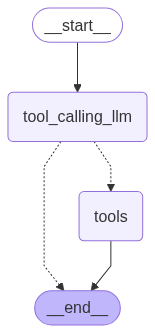

In [34]:
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
messages=graph.invoke({"messages":HumanMessage(content="What is attention is all you need")})
for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

What is attention is all you need
================================== Ai Message ==================================
Tool Calls:
  wikipedia (f41grnn7j)
 Call ID: f41grnn7j
  Args:
    query: Attention is all you need
================================= Tool Message =================================
Name: wikipedia

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi


In [37]:
messages

{'messages': [HumanMessage(content='What is attention is all you need', additional_kwargs={}, response_metadata={}, id='ebf2d161-c37f-45ff-be07-93deeb143886'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'f41grnn7j', 'function': {'arguments': '{"query":"Attention is all you need"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1287, 'total_tokens': 1370, 'completion_time': 0.150909091, 'prompt_time': 0.024426858, 'queue_time': 0.256821272, 'total_time': 0.175335949}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4fc584e2-f3f1-41e9-be45-2cd5a46ccc3f-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Attention is all you need'}, 'id': 'f41grnn7j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1287, 'output_tokens': 83, 'total_tokens': 1370}),
  ToolMessage(content='Pa

In [39]:
messages=graph.invoke({"messages":HumanMessage(content="Todays weather in India")})
for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

Todays weather in India
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (a05cqn4m1)
 Call ID: a05cqn4m1
  Args:
    query: Todays weather in India
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Delhi Weather Forecast for March 8, 2025: Sunny, Breezy and ...", "url": "https://www.moneycontrol.com/travel/delhi-weather-forecast-for-march-8-2025-sunny-breezy-and-warming-up-article-12959507.html", "content": "Delhi wakes up to clear skies and a crisp morning on Saturday, March 8, 2025. Strong surface winds will sweep through the city, keeping the weather dry and breezy throughout the day. According to the India Meteorological Department (IMD), the day will start on a chilly note at 12°C, gradually warming up to 31°C by the afternoon. With no rain in sight, De